In [1]:
from IPython.display import HTML
import re
import copy

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon

import numpy as np
from scipy.special import binom
import itertools
import requests


from io import StringIO as sio
from io import BytesIO as csio

## set default matplotlib font and font size
typeface='helvetica'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

import os,random
from itertools import permutations

# bt=imp.load_source('baltic_bacter','/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella copy/visualisation_code/baltic.py')

import sys
sys.path.append('/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella copy/visualisation_code')
import baltic as bt



In [2]:
segments=['NC_007384','NC_009345','NC_009346', 'NC_009347']
segment_name=['chromosome','spA','spB', 'spC']

colours={'NC_007384':(0.2981622478541206, 0.44644367598435458, 0.64719724652229571),
        'NC_007385':"#E69F00",
        'NC_009345':"#0072B2",
        'NC_009346':"#009E73",
        'NC_009347':"#D55E00"}

cmap=mpl.cm.viridis
cumulative_displace=0 ## this tracks the "current" x position, so trees are plotted one after another

trees={} ## dict
for segment in segments:
    print(segment,)
    path='/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella copy/combined/'
    fname= 'Sonnei_equal.' + segment + '.tree'
    tree_path=os.path.join(path,fname)   
    ll=bt.loadNexus(tree_path, absoluteTime=False) ## load tree
    trees[segment]=ll.collapseBranches(lambda k:k.traits['posterior']<0.25) ## add tree object to dict
    if segment=='NC_007384':
        subset_tips=[w.name for i,w in enumerate(ll.getExternal()) if i%5==0]
    trees[segment]=trees[segment].reduceTree([w for w in ll.getExternal() if w.name in subset_tips]) ## reduce tree to every 5th tip, to make plotting faster later
    
print('\nDone!')


NC_007384
NC_009345
NC_009346
NC_009347

Done!


In [3]:
tip_positions={x:{} for x in segments} ## remember the position of each tip in each tree

for t,tr in enumerate(trees.keys()): ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    for k in cur_tree.Objects:
        if k.branchType=='leaf':
            tip_positions[tr][k.name]=(k.height,k.y) ## remember (X, Y) position of tip

cmap=mpl.cm.Spectral

tip_positions={x:{} for x in trees} ## remember the position of each tip in each tree

for t,tr in enumerate(trees.keys()): ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    for k in cur_tree.Objects:
        if k.branchType=='leaf':
            tip_positions[tr][k.name]=(k.height,k.y) ## remember (X, Y) position of tip

cmap=mpl.cm.Spectral

for X in range(10): ## 10 untangling iterations
    print('iteration %d'%(X+1))
    for t,tr in enumerate(segments): ## iterate over each tree
        print(tr)
        ptr=segments[t-1] ## previous tree
        ntr=segments[t] ## next tree
        seg=trees[ptr] ## fetch appropriate tree
        nex_seg=trees[ntr]
        for k in sorted(nex_seg.Objects,key=lambda q:q.height): ## iterate over branches from most recent to oldest
            if k.branchType=='node': ## can only sort nodes
                leaves=[w.leaves if w.branchType=='node' else [w.name] for w in k.children] ## descendent tips in current order
                
#                 leaves=[[seg.tipMap[tip] for tip in w.leaves] if w.branchType=='node' else [w.name] for w in k.children] ## descendent tips in current order
                
                for c in range(len(leaves)):
#                     leaves[c]=sorted(leaves[c],key=lambda x:tip_positions[ntr][x][1]) ## sort leaves according to their positions in the next tree
                    leaves[c]=sorted(leaves[c],key=lambda x:tip_positions[ntr][x][1] if x in tip_positions[ntr] else 0.0) ## sort leaves according to their positions in the next tree
                
                ys=[sorted([tip_positions[ntr][w][1] for w in cl if w in tip_positions[ntr]]) for cl in leaves] ## extract y positions of descendents
                merge_ys=sum(ys,[]) ## flatten list of tip y coordinates
                ypos=range(int(min(merge_ys)),int(max(merge_ys))+1) ## get y positions of tips in current order
                order={i:x for i,x in enumerate(leaves)} ## dict of tip order: tip name
                
                new_order=sorted(order.keys(),key=lambda x:-np.mean([(tip_positions[ptr][order[x][w]][1]-ypos[w]) for w in range(min([len(order[x]),len(ypos)])) if order[x][w] in tip_positions[ptr]])) ## get new order by sorting existing order based on y position differences
                
#                 new_order=sorted(order.keys(),key=lambda x:-np.mean([(tip_positions[ptr][order[x][w]][1]-ypos[w]) for w in range(len(order[x]))])) ## get new order by sorting existing order based on y position differences
                
                if new_order!=range(len(leaves)): ## if new order is not current order
                    k.children=[k.children[i] for i in new_order] ## assign new order of child branches
                    nex_seg.drawTree() ## update y positions

                    for w in nex_seg.Objects: ## iterate over objects in next tree
                        if w.branchType=='leaf':
                            tip_positions[ntr][w.name]=(w.height,w.y) ## remember new positions
                
        if t==0: ## if first tree
            trees[segments[t]].drawTree() ## update positions
            lvs=sorted([w for w in trees[segments[t]].Objects if w.branchType=='leaf'],key=lambda x:x.y) ## get leaves in y position order
            
            norm=mpl.colors.Normalize(0,len(lvs))
            pos_colours={w.name:cmap(norm(w.y)) for w in lvs} ## assign colour


iteration 1
NC_007384


/opt/homebrew/Caskroom/miniconda/base/envs/plasmids/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniconda/base/envs/plasmids/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NC_009345
NC_009346
NC_009347
iteration 2
NC_007384
NC_009345
NC_009346
NC_009347
iteration 3
NC_007384
NC_009345
NC_009346
NC_009347
iteration 4
NC_007384
NC_009345
NC_009346
NC_009347
iteration 5
NC_007384
NC_009345
NC_009346
NC_009347
iteration 6
NC_007384
NC_009345
NC_009346
NC_009347
iteration 7
NC_007384
NC_009345
NC_009346
NC_009347
iteration 8
NC_007384
NC_009345
NC_009346
NC_009347
iteration 9
NC_007384
NC_009345
NC_009346
NC_009347
iteration 10
NC_007384
NC_009345
NC_009346
NC_009347


corresponding tip not found
corresponding tip not found
corresponding tip not found
corresponding tip not found
corresponding tip not found
corresponding tip not found
corresponding tip not found
corresponding tip not found
corresponding tip not found
corresponding tip not found
corresponding tip not found
corresponding tip not found
corresponding tip not found
corresponding tip not found
corresponding tip not found


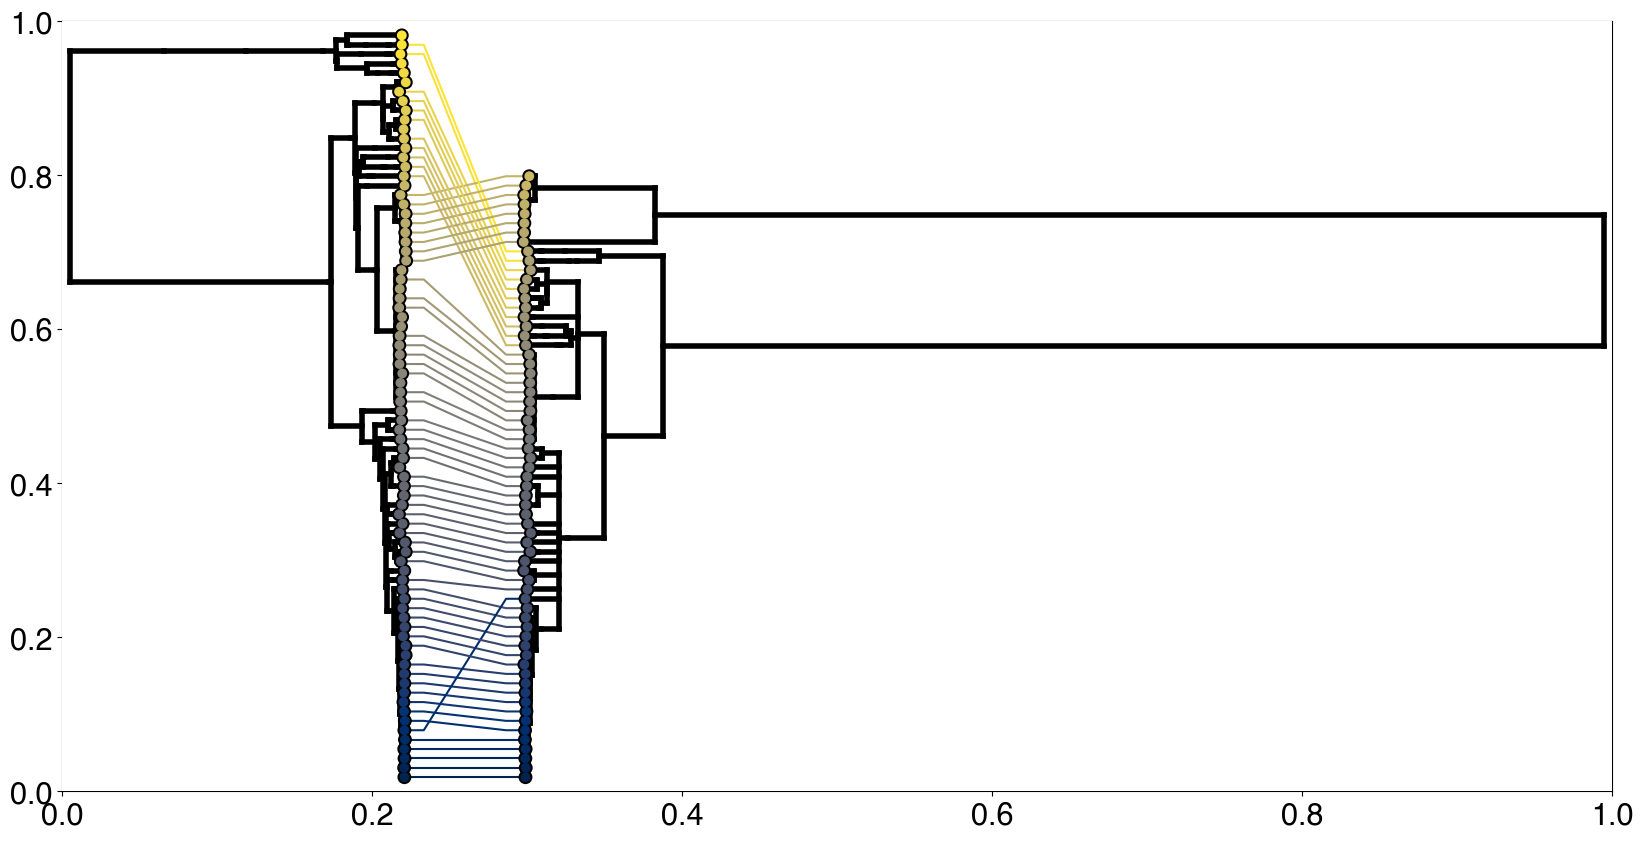

In [4]:
fig = plt.subplots(figsize=(20,10),facecolor='w')

gs = GridSpec(1, 1,hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])

tree1=trees['NC_007384']
tree2=trees['NC_009345']

cmap=mpl.cm.cividis
x_attr=lambda k: k.height ## branch x position is determined by height
c_func='k'
ct_func=lambda k: cmap(k.y/float(tree1.ySpan)) ## call colour map with fraction that represents the y position of a tip (returns colour)

tree1.plotTree(ax,x_attr=x_attr,width=4,colour=c_func) ## plot black tree
tree1.plotPoints(ax,x_attr=x_attr,size=50,colour=ct_func,zorder=100) ## plot circles at tips


skip=tree1.treeHeight*0.35 ## skip this many units between trees
x_attr=lambda k: tree1.treeHeight+skip+tree2.treeHeight-k.height ## for tree2 we'll offset x coordinates by the height of the tree and invert branches
tree2.plotTree(ax,x_attr=x_attr,width=4,colour=c_func) ## plot black tree
tree2.plotPoints(ax,x_attr=x_attr,size=50,colour=ct_func,zorder=100) ## plot circles at tips

for k in filter(lambda x: x.branchType=='leaf',tree1.Objects): ## grab leaf objects in tree1
    x=k.height ## get height
    y=k.y ## get y position

    try:
        matching_tip=tree2.getBranches(lambda x: x.branchType=='leaf' and x.name==k.name) ## fetch corresponding branch in tree2
        match_y=matching_tip.y
        xs=[x,tree1.treeHeight+0.15*skip,tree1.treeHeight+skip-0.15*skip,x_attr(matching_tip)] ## x coordinates for tangleline
        ys=[y,y,match_y,match_y] ## y coordinates for tangleline
        ax.plot(xs,ys,color=cmap(y/float(tree1.ySpan))) ## plot tangleline
    except Exception as e:
        print('corresponding tip not found')
        
   
[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]

ax.tick_params(axis='x',size=0)
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_ylim(-1,tree1.ySpan+1) ## set y limits
ax.set_xlim(-5,tree1.treeHeight+skip+tree2.treeHeight+5)

plt.show()


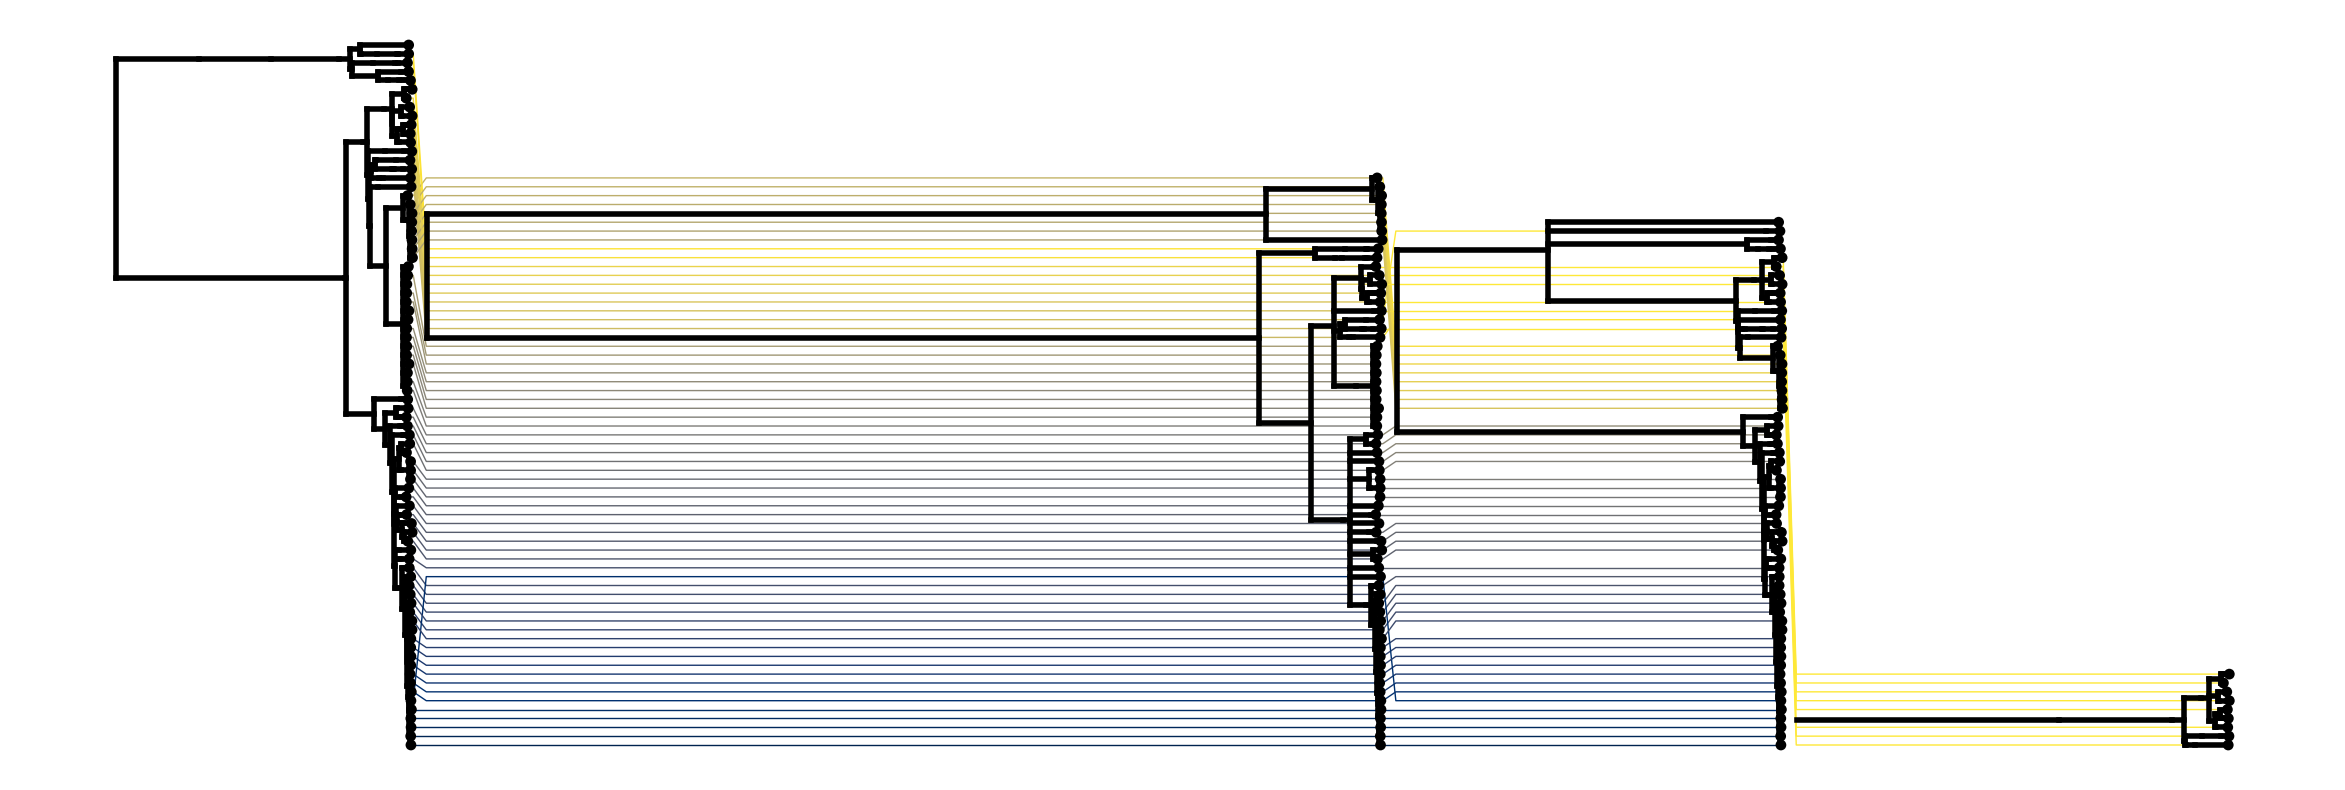

Figure saved as /Users/nmueller/Documents/github/Plasmids-Text/Figures/Sonnei_tangletree.pdf


In [5]:
fig,ax = plt.subplots(figsize=(30,10),facecolor='w')

segments_new_order = ['NC_007384','NC_009345','NC_009347', 'NC_009346']

displaceAmount=10
for t,tr in enumerate(segments_new_order): ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    x_attr=lambda k: k.height+cumulative_displace
    ct_func=lambda k: cmap(tip_positions['PB1'][k.name][1]/float(cur_tree.ySpan))
            
    cn_func='k'
    
    cur_tree.plotTree(ax,x_attr=x_attr,width=4,colour='k')
    cur_tree.plotPoints(ax,x_attr=x_attr,size=30,colour='k',zorder=100)
    
    for k in cur_tree.Objects: ## iterate over branches
        if k.branchType=='leaf': ## if leaf...
            y=k.y
            pos_in_first_tree=tip_positions['NC_007384'][k.name][1] ## fetch y coordinate of same tip in the first tree
            frac_pos=pos_in_first_tree/float(cur_tree.ySpan) ## normalize coordinate to be within interval [0.0,1.0]

            if t != len(segments_new_order) - 1:  # As long as we're not at the last tree
                if k.name in tip_positions[segments_new_order[t+1]]:  # Check if the tip exists in the next tree
                    next_x, next_y = tip_positions[segments_new_order[t+1]][k.name]  # Fetch coordinates of same tip in next tree
                    next_x += cumulative_displace + cur_tree.treeHeight + displaceAmount  # Adjust x coordinate
                    nextIncrement = cumulative_displace + cur_tree.treeHeight
                    ax.plot([x_attr(k), nextIncrement + 0.05 * displaceAmount, nextIncrement + 0.95 * displaceAmount, next_x],
                            [y, y, next_y, next_y], lw=1, ls='-', color=cmap(frac_pos), zorder=0)  # Connect current tip with same tip in the next tree
                else:
                    continue  # Skip this tip if it's not in the next tree

    cumulative_displace+=cur_tree.treeHeight+displaceAmount ## increment displacement by the height of the tree

[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]

ax.tick_params(axis='x',size=0)
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

# ax.set_ylim(-1,cur_tree.ySpan+1) ## set y limits
# ax.set_xlim(-5,cumulative_displace+5)

plt.show()
figname =  '/Users/nmueller/Documents/github/Plasmids-Text/Figures/Sonnei_tangletree.pdf'
try:
    fig.savefig(figname, bbox_inches='tight')
    print(f"Figure saved as {figname}")
except Exception as e:
    print(f"Error saving figure: {e}")
plt.close(fig)


In [6]:
# Initialize an empty list to store the names
names = []

# Initialize a flag to start capturing names after the specified line is found
capture_names = False

# Open the XML file
with open('/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella copy/xmls/SonFlex_equal_rep0.xml', 'r') as file:
    for line in file:
        # Check if the line is the one after which we start capturing names
        if '<trait spec="TraitSet" traitname="date" dateFormat="yyyy-M-dd" id="traitSet">' in line:
            capture_names = True
            continue

        # If the flag is set, start capturing names
        if capture_names:
            # Check if the line matches the expected pattern for the names
            if line.strip().startswith('AUSMDU'):
                name = line.strip()
                names.append(name)

# Create a dictionary to map IDs to dates
name_date_map = {}
for name in names:
    # Split the string on '=' and remove the trailing comma
    id_part, date_part = name.split('=')
    date = date_part.rstrip(',')
    name_date_map[id_part] = date

import re

# Define the pattern to search for (assuming 'AUSMDU' followed by digits)
pattern = re.compile(r'AUSMDU\d+')

# File paths
input_file = '/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella copy/combined/SonFlex_equal.mapped.tree'
output_file = '/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella copy/combined/SonFlex_equal_updated.mapped.tree'

# Open the original file and a new file for the updated content
with open(input_file, 'r') as file, open(output_file, 'w') as outfile:
    for line in file:
        # Replace occurrences of the pattern with 'AUSMDU..|date'
        updated_line = pattern.sub(lambda x: f"{x.group()}|{name_date_map.get(x.group(), 'unknown_date')}", line)
        outfile.write(updated_line)

print("File updated successfully.")



File updated successfully.


In [14]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec

import requests
from io import StringIO as sio

# bt=imp.load_source('baltic_bacter','/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella copy/visualisation_code/baltic.py')

colours={'plasmid':'#E69F00',
        'son':"#44AA99",
        'flex':"#999933"}

colours2={'0+1':colours['plasmid'],
          '1+1':colours['plasmid'],
          '0+0':colours['son'],
          '1+0':colours['flex']}




fname= 'SonFlex_equal_updated.mapped.tree'
tree_path=os.path.join(path,fname)   
ll=bt.loadNexus(tree_path,date_fmt='%Y-%m-%d') ## load tree
ll.treeStats() ## report stats about tree

traitName='seg1' ## trait which will be used to disassemble the tree
branchWidth=2

print(ll.root.absoluteTime,ll.root.parent.index)
tree_strings={'0+0':[],'0+1':[],'1+0':[],'1+1':[],'ancestor':[]}
subtype_trees={'0+0':[],'0+1':[],'1+0':[],'1+1':[],'ancestor':[]}

for l in ll.Objects: ## iterate over branches
    k=l ## branch
    kp=l.parent ## branch's parent
    
    ## get current node's and its parent's trait states
    kloc=str(round(k.traits['state'])) + '+' + str(round(k.traits['seg1'])) ## get branch trait value
    if traitName in k.parent.traits: ## if parent has trait
        kploc=str(round(kp.traits['state'])) + '+' + str(round(kp.traits['seg1'])) ## get parental trait value
        kpc=kploc
    else: ## parent does not have trait value, must be at root
        kploc='ancestor'
        kpc='ancestor'

    kc=kloc ## kc is branch trait value, kpc is branch parent trait value
    
    ## if states do not match
    if kc!=kpc:
        traverse_condition=lambda w: (str(round(w.traits['state'])) + '+' + str(round(w.traits['seg1'])))  ==kc ## only traverse tree for as long as branches are in the branch state
        # print('subtree resulting from %s>%s switch, traversing within %s'%(kpc,kc,kc))
        subtree=ll.subtree(k,traverse_condition=traverse_condition) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
    
        
        if subtree: ## if the conditional subtree traversal failed because no tips were encountered None is returned
            subtree.traverse_tree() ## traverse subtree
            subtree.sortBranches() ## sort branches
            tree_strings[kc].append(subtree.toString()) ## remember subtree string, subtree object itself
            subtype_trees[kc].append((kpc,subtree)) ## add parental state and subtree to list



Tree height: 1937.155848
Tree length: 14200.623151
strictly bifurcating tree
annotations present

Numbers of objects in tree: 799 (399 nodes and 400 leaves)

83.59278621362637 Root


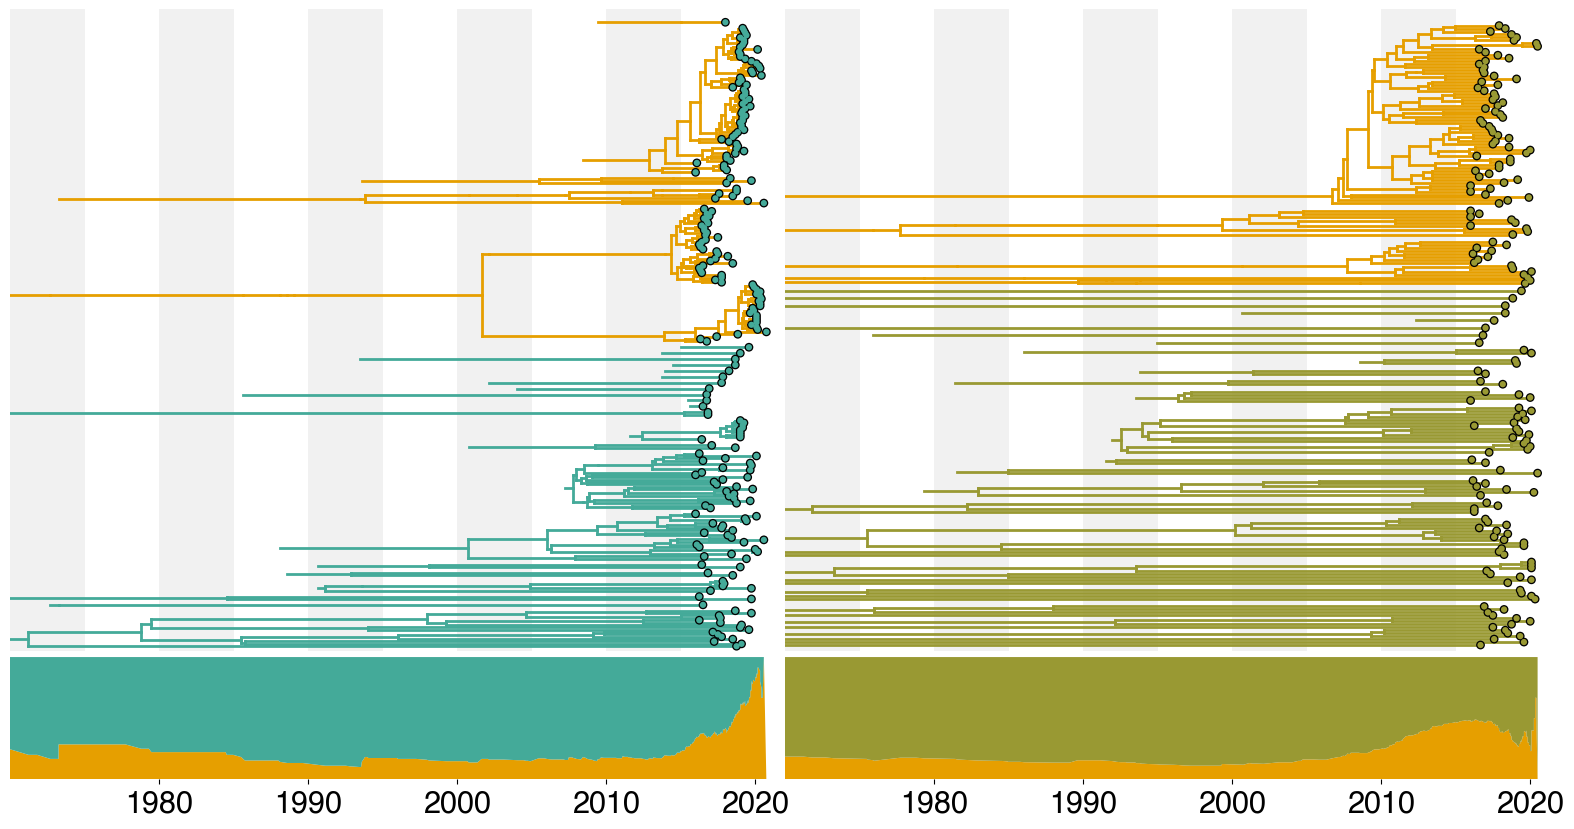

In [15]:

fig = plt.figure(figsize=(20, 10),facecolor='w') ## create figure
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 0.2], wspace=0.0)  # Adjust the ratio as needed
ax=plt.subplot(gs[0],facecolor='w') ## create axes
ax2 = plt.subplot(gs[1], facecolor='w') ## for the freq plot
ax3 = plt.subplot(gs[2], facecolor='w') ## for the freq plot
ax4 = plt.subplot(gs[3], facecolor='w') ## for the freq plot

tipSize=20
cumulative_y={'0':0, '1':0}


x_attr=lambda k: k.absoluteTime
c_func = lambda k: colours['plasmid'] if str(round(k.traits['seg1'])) == '1' else colours['son'] if str(round(k.traits['state'])) == '0' else colours['flex']
c_func_tips = lambda k: colours['son'] if str(round(k.traits['state'])) == '0' else colours['flex']

lineages = {}  # Dictionary to store lineages

for subtype in ['0+1','0+0','1+1','1+0']: ## iterate over trait values
    for t,tr in enumerate(sorted(subtype_trees[subtype],key=lambda x:(-x[1].root.absoluteTime,len(x[1].Objects)))): ## iterate over extracted subtrees sorted according to their root height and their size
        origin,loc_tree=tr ## get origin of subtree, subtree itself

        state = subtype.split('+')[0]
        
        y_attr=lambda k: k.y+cumulative_y[str(round(k.traits['state']))]

        if state=='0':
            loc_tree.plotTree(ax,x_attr=x_attr,y_attr=y_attr,colour=c_func)
            loc_tree.plotPoints(ax,x_attr=x_attr,y_attr=y_attr,size=tipSize,colour=c_func_tips,zorder=100)
        else:
            loc_tree.plotTree(ax2,x_attr=x_attr,y_attr=y_attr,colour=c_func)
            loc_tree.plotPoints(ax2,x_attr=x_attr,y_attr=y_attr,size=tipSize,colour=c_func_tips,zorder=100)
        
        oriC='dimgrey' if origin=='ancestor' else c_func(loc_tree.root.parent)
        
        # oriX=loc_tree.root.absoluteTime-loc_tree.root.length
        # oriY=loc_tree.root.y+cumulative_y[state]
        
        # ax.scatter(oriX,oriY,100,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
        cumulative_y[state]+=loc_tree.ySpan+1.5 ## increment y displacement

        for l in loc_tree.Objects:  # Iterate over branches
            k = l  # Branch
            # Check if the category already exists in the dictionary
            if subtype not in lineages:
                lineages[subtype] = []  # Initialize an empty list for this category
        
            # Append the lineage (start and end points) to the appropriate category
            lineages[subtype].append((k.parent.absoluteTime, k.absoluteTime))


time_points = set()
lineage_count_by_category_over_time = {}
for category in lineages:
    for start, end in lineages[category]:
        if start is not None:
            time_points.add(start)
        if end is not None:
            time_points.add(end)

sorted_time_points = sorted(time_points)
# Initialize lineage_count_by_category_over_time
for time_point in sorted_time_points:
    lineage_count_by_category_over_time[time_point] = {cat: 0 for cat in lineages}

for time_point in sorted_time_points:
    for category in lineages:
        count = 0
        for start, end in lineages[category]:
            if start is not None and end is not None:
                if start <= time_point < end:
                    count += 1
        lineage_count_by_category_over_time[time_point][category] = count


lineage_freq_by_category_over_time = {}

# Initialize lineage_count_by_category_over_time
for time_point in sorted_time_points:
    lineage_freq_by_category_over_time[time_point] = {state: {category: 0 for category in ['0', '1']} for state in ['0', '1']}

for time_point in sorted_time_points:
    for state in ['0','1']:
        sum=0.0
        for category in ['0','1']:
            sum += lineage_count_by_category_over_time[time_point][state + '+' + category]
            
        for category in ['0','1']:
            if sum>0:
                lineage_freq_by_category_over_time[time_point][state][category] = lineage_count_by_category_over_time[time_point][state + '+' + category]/sum
            else:
                lineage_freq_by_category_over_time[time_point][state][category] = 0

  
        
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax2.xaxis.tick_bottom()
ax2.yaxis.tick_left()


[ax.spines[loc].set_visible(False) for loc in ['top','right','left', 'bottom']]
[ax2.spines[loc].set_visible(False) for loc in ['top','right','left', 'bottom']]

ax.tick_params(axis='y',size=0)
ax.set_yticklabels([])
ax.set_ylim(cumulative_y['0'],-5)
ax.set_xlim(1970, 2022)
ax.set_xticklabels([])
ax.tick_params(axis='x', which='both', length=0)

ax2.tick_params(axis='y',size=0)
ax2.set_yticklabels([])
ax2.set_ylim(cumulative_y['1'],-5)
ax2.set_xlim(1970, 2022)
ax2.set_xticklabels([])
ax2.tick_params(axis='x', which='both', length=0)

[ax.axvspan(i,i+5,facecolor='lightgrey',edgecolor='none',alpha=0.3,zorder=0) for i in range(1970,2020,10)] ## add timeline    
[ax2.axvspan(i,i+5,facecolor='lightgrey',edgecolor='none',alpha=0.3,zorder=0) for i in range(1970,2020,10)] ## add timeline    



# Prepare data for the frequency plot
time_points1 = sorted(lineage_freq_by_category_over_time.keys())
categories = ['0','1']
stack_data1 = []
color_list1 = []
stack_data2 = []
color_list2 = []


for category in categories:
    counts = [lineage_freq_by_category_over_time[tp]['0'][category] for tp in time_points1]
    stack_data1.append(counts)
    color_list1.append(colours2['0'+'+'+category])  # Get the color for this category

for category in categories:
    counts = [lineage_freq_by_category_over_time[tp]['1'][category] for tp in time_points1]
    stack_data2.append(counts)
    color_list2.append(colours2['1'+'+'+category])  # Get the color for this category


# Create the area plot
ax3.stackplot(time_points1, stack_data1[::-1], labels=categories, colors=color_list1[::-1])
# Adding labels, title, and legend
ax3.set_xlim(1970, 2022)

ax4.stackplot(time_points1, stack_data2[::-1], labels=categories, colors=color_list2[::-1])
# Adding labels, title, and legend
ax4.set_xlim(1970, 2022)

# Set x-axis ticks every 10 years from 1980 to 2020
ax3.set_xticks([1980, 1990, 2000, 2010, 2020])
ax3.set_xticklabels(['1980', '1990', '2000', '2010', '2020'])
ax4.set_xticks([1980, 1990, 2000, 2010, 2020])
ax4.set_xticklabels(['1980', '1990', '2000', '2010', '2020'])

# Remove x-axis labels and ticks from ax
# Adjust the spacing
plt.subplots_adjust(hspace=0.00)  # Adjust this value as needed to reduce space

# Remove spines for ax2
[ax3.spines[loc].set_visible(False) for loc in ['top', 'right', 'left', 'bottom']]
[ax4.spines[loc].set_visible(False) for loc in ['top', 'right', 'left', 'bottom']]
ax4.set_yticks([])
ax4.set_yticklabels([])
ax3.set_yticks([])
ax3.set_yticklabels([])


plt.show()

figname =  '/Users/nmueller/Documents/github/Plasmids-Text/Figures/SonFlex.exploded.pdf'
fig.savefig(figname, bbox_inches='tight')
plt.close(fig)

In [8]:
print(lineage_freq_by_category_over_time[2009.6522841858712]['1'])

{'0': 0.7555555555555555, '1': 0.24444444444444444}


In [16]:
import sys
from augur import frequencies,frequency_estimators
from Bio import Phylo


tips=[k.name for k in ll.Objects if k.branchType=='leaf'] ## get tip names
tipDates=[k.split('|')[-1] for k in tips] ## isolate collection date from tip name
dates=[bt.decimalDate(k,variable=True) for k in tipDates] ## convert dates into decimal dates

try:
    tr = Phylo.read(csio(ll.toString()), "newick") ## create a Bio.Phylo tree from the baltic tree
except:
    tr = Phylo.read(sio(ll.toString()), "newick")
    
for k in ll.Objects:
    if k.length<0.0:
        k.length=0.0 ## convert negative branch lengths to 0.0

for n,nd in enumerate(tr.get_terminals()):
    if hasattr(nd,'attr')==False:
        setattr(nd,'attr',{})
    nd.attr['num_date'] = bt.decimalDate(nd.name.split('|')[-1],variable=True) ## assign collection date to Bio.Phylo tips

pivots = np.array(frequency_estimators.make_pivots(200,np.array(dates))) ## create time grid for clade frequencies
bfq=frequencies.tree_frequencies(tr,min_clades=10,node_filter=None,pivots=pivots,verbose=True) ## create a frequencies object
print('Done!')
bfq.estimate_clade_frequencies() ## estimate smoothed trajectories


ModuleNotFoundError: No module named 'augur'

In [17]:
for n,nd in enumerate(ll.traverse_tree(include_condition=lambda k:True)): ## frequencies are estimated in traversal order
    if nd.branchType=='node':
        nd.traits['cf']=bfq.frequencies[n] ## assign frequency vector to node
fig = plt.subplots(figsize=(20,20),facecolor='w')

gs = GridSpec(2, 2,height_ratios=[6,1],width_ratios=[6,1],hspace=0.0,wspace=0.0)
ax_tree = plt.subplot(gs[0])
ax_muller = plt.subplot(gs[2],sharex=ax_tree)
ax_genome = plt.subplot(gs[1],sharey=ax_tree)

condition=lambda x:x.branchType=='node' and ((len([1 for k in x.children if k.branchType=='node' and len(k.leaves)>=15])==2) or (traitName in x.parent.traits and x.traits[traitName]!=x.parent.traits[traitName]) or x==ll.root)

ll.sortBranches(descending=False)
traitName='seg1'
def plot_subclade(ax, cfreq, clade, pivots):
    """ Iteratively plot clade frequencies.
        Code written by Richard Neher.
    """
    
    if traitName in clade.traits:
        if clade.traits[traitName]>0.5:
            cmap=mpl.cm.Reds
        else:
            cmap=mpl.cm.Blues
    else:
        cmap=mpl.cm.Purples_r
    
    if clade.branchType=='node':
        if condition(clade):
            fr=clade.height/ll.treeHeight
            colour=cmap(fr)
            ec='none'
            cfs=clade.traits['cf']
            inc=cfs
            idx0,idx1=None,None

            idx_cfs=np.where((cfreq+inc)>0.0) ## identify indices where frequencies are >0.0
            idx_pvt=np.where(clade.absoluteTime<pivots) ## identify indices where pivots are greater than date of node 
            idx0=max([min(idx[0]) for idx in [idx_cfs,idx_pvt] if len(idx[0])>0]) ## pick the one that's higher
            earliest=min([bt.decimalDate(k.split('|')[-1],variable=True) for k in clade.leaves])
            idx_lf=np.where(earliest<pivots) ## identify indices where pivots are greater than date of node 
            idx1=idx_lf[0][0]
            
            i=clade.traits['cf']
            p=pivots
            c=cfreq
            
            I=i[idx0:]
            P=p[idx0:]
            C=c[idx0:]
            
            ax.fill_between(p[idx1:],c[idx1:],c[idx1:]+inc[idx1:],
                        facecolor=colour,
                        edgecolor=ec,alpha=1.0,
                        linestyle='-',zorder=sorted([k.height for k in ll.Objects]).index(clade.height))
            
            ax.plot(p[idx1:],c[idx1:],ls='-',color='k',lw=2,zorder=int(clade.height*100001))
            ax.plot(p[idx1:],c[idx1:]+inc[idx1:],ls='-',color='k',lw=2,zorder=int(clade.height*100001))
            
            ax.plot(p[idx0:idx1],c[idx0:idx1],ls='--',color='k',lw=1,zorder=int(clade.height*100001))
            ax.plot(p[idx0:idx1],c[idx0:idx1]+inc[idx0:idx1],ls='--',color='k',lw=1,zorder=int(clade.height*100001))
            
    tmp_cfreq = np.copy(cfreq)
    
    for child in clade.children:
        if child.branchType=='node':
            tmp_cfreq = plot_subclade(ax, tmp_cfreq, child, pivots)
    
    return cfreq+clade.traits['cf']

cfreq = np.zeros_like(pivots) ## empty list to hold trajectories
plot_subclade(ax_muller, cfreq, ll.root, pivots)

background_tree=lambda k: condition(k)==False
focus_tree=lambda k: condition(k)
x_attr=lambda k: k.absoluteTime
c_func=lambda k: mpl.cm.Reds(k.height/ll.treeHeight) if k.traits[traitName]>0.5 else mpl.cm.Blues(k.height/ll.treeHeight)

ll.plotTree(ax_tree,target=background_tree,colour=c_func,x_attr=x_attr) ## black regular tree
# ll.plotTree(ax_tree,target=focus_tree,x_attr=x_attr,colour=c_func,width=3) ## coloured focus tree

c_func=lambda k: mpl.cm.Reds(0.3) if k.traits[traitName]>0.5 else mpl.cm.Blues(0.3)

ll.plotPoints(ax_tree,x_attr=x_attr,size=20,colour=c_func,zorder=100)

segments=['seg1'] ## keys for traits
for k in ll.Objects: ## iterate over branches
    for s in range(len(segments)): ## iterate over trait keys
        c='indianred' if k.traits[segments[s]]>0.5 else 'steelblue' ## red for V, blue for Y
        lineage=plt.Rectangle((s,k.y-0.5),1,1,facecolor=c,edgecolor='none') ## rectangle with height and width 1, at y position of tip and at the index of the key
        ax_genome.add_patch(lineage) ## add coloured rectangle to plot


ax_genome.set_xticks(np.arange(0.5,len(segments)+0.5))
ax_genome.set_xticklabels(segments,rotation=90)
[ax_genome.axvline(x,color='w') for x in range(len(segments))]
  
ats=[k.absoluteTime for k in ll.Objects]
fr=0.2
ax_muller.set_xlim(min(pivots)-20,max(pivots))
ax_tree.set_xlim(1980,max(ats)+fr)
ax_genome.set_xlim(0,5)

ax_muller.set_ylim(0,1)
# ax_muller.invert_yaxis()
ax_tree.set_ylim(-5,ll.ySpan+5)

[ax_muller.spines[loc].set_visible(False) for loc in ['top','right','left']] ## no axes
[ax_tree.spines[loc].set_visible(False) for loc in ['top','right','left']] ## no axes
[ax_genome.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']] ## no axes

ax_tree.tick_params(axis='x',size=0) ## no labels
ax_muller.tick_params(axis='y',size=0)
ax_muller.tick_params(axis='x',labelsize=24)
ax_genome.tick_params(size=0,labelsize=24)
ax_muller.set_yticklabels([])
ax_tree.set_yticklabels([])
ax_genome.xaxis.set_ticks_position('top')

ax_muller.grid(axis='x')
ax_tree.grid(axis='x')
plt.show()


NameError: name 'bfq' is not defined